#  Hartmann (1977)

Authors: Jonathan Frassineti and Pietro Bonfà

**Disclaimer**: this is a work in progress!

The simulations that follow reproduce the case of Cu for different transversal magnetic field 
applied along the [1,0,0], [1,1,0] and [1,1,1] directions.

Description of Hartmann findings and method goes here.

The different reduced damping rates 'b_Har' are shown in the figure.
'b_Har' is related to the width of the Gaussian field distribution 'delta_TF' through the formula:

$$
b_{Har} = \frac{4\pi\Delta_{TF}}{\mu_0\gamma_{Cu}\hbar}
$$

A larger 'delta_TF' means a larger width of Gaussian field distribution, and so a higher
depolarization for the muon polarization signal due to the presence of larger values of internal fields,
randomly distributed around the muon.
For the physical aspects, see A.Yaouanc and P. de Réotier, Muon Spin Rotation, Relaxation and Resonance,
Oxford University Press, 2010, chapter 6, Fig. 6.19 (left).

In [1]:
try:
    from undi import MuonNuclearInteraction
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../undi')
    from undi import MuonNuclearInteraction
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import moment 
from scipy.signal import savgol_filter

Define physical constants.

In [2]:
COMPUTE = False

fields = 15 # Number of transversal external fields applied.
axis = 3 # Number of different axis where B is applied.
angtom = 1.0e-10 # m, Angstrom.
a = 3.597 # Cu lattice constant, in Angstrom.
elementary_charge = 1.6021766e-19 # Elementary charge, in Coulomb = Ampere*second.
epsilon0 = 8.8541878e-12 # Vacuum permittivity, in Ampere^2*kilogram^−1*meter^−3*second^4.
mu0 = 4*np.pi*1e-7
h = 6.6260693e-34 # J*s, Planck's constant.
hbar = h/(2*np.pi) # J*s, reduced Planck's constant.

Quadrupole_moment_Cu = - 0.22e-28 # m^2, quadrupole moment of Cu.
gamma_mu = 2*np.pi*135.5e6 # sT^-1, gyromagnetic ratio of muon.
gamma_Cu = 71.118e6 # sT^-1, gyromagnetic ratio of Cu.
omega = -1.378879e6/3. # Quadrupolar resonance frequency of Cu, in s^-1.

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    https://stackoverflow.com/a/6802723
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

Define the atomic positions for muon and Cu nuclei.
We also rotate the corresponding atomic positions (and so the axis) in order to have
the external fields along x, and the muon spin along z.

These are the original positions.

In [3]:
pos = np.array ([[0., 0., 0.5],
                 [0. ,  0.,  0.],
                 [0. ,  0.,  1.],
                 [0.5 ,  0.,  0.5],
                 [-0.5 ,  0.,  0.5],
                 [0. ,  0.5,  0.5],
                 [0. ,  - 0.5,  0.5]])*angtom*a

Define the atomic structure.

In [4]:
def gen_atoms(positions):
    """
    This function returns the input for UNDI assuming that the muon
    is the first position.
    """
    return [
                {'Position': positions[i],
                    'Label': 'mu'
                } if i == 0 else # first element is the muon
                
                {'Position': positions[i],
                    'Label': '63Cu',
                    'OmegaQmu': 3*omega
                } for i in range(7) # 6 atoms + 1 muon
            ]

## Polarization function.

The muon polarization is obtained with the method introduced by Celio.

In [5]:
time_max = 20e-6 # Value of the temporal window, in microseconds.
freq_max = 400e6 # Value of the sampling frequency, in Hz. 
                 # This is 10 times the maximum Larmor frequency used in this sample, 
                 # about 40 MHz. This has been done to avoid aliasing.
                 
steps = int(freq_max*time_max) # Number of steps used to simulate the signal.
tlist = np.linspace(0,time_max,steps) # Time scale, in seconds.

Define the applied external transverse magnetic fields, in Tesla.
With these values, we obtain a maximum applied external field of 0.58 T.

In [6]:
factors = np.logspace(np.log2(1),np.log2(30),fields,base=2)
TF = factors * np.abs(omega)/gamma_Cu

Used to align the magnetic fields along x.

In [7]:
B_ext = np.array([1.,0.,0.])

This is the Celio method for the polarization function.

In [8]:
if COMPUTE:
    print("Computing signal for positive EFGs...", end='', flush=True)
    
    signal = np.zeros((fields, axis, steps))
    
    for i in range(fields):
        #| Align the magnetic fields along x.
        B = TF[i]*B_ext
    
        # do not rotate aanything yet
        R = np.eye(3)
        rpos = np.dot(R,pos.T).T
        NS = MuonNuclearInteraction(gen_atoms(rpos), external_field=B, log_level='info')
        signal[i,0,:] = NS.celio(tlist,  k=1) + NS.celio(tlist,  k=1)
        del NS
        
        # rotate 45 deg with axis=z to get [110] along B direction, which is x
        R = rotation_matrix([0,0,1], np.pi/4)
        rpos = np.dot(R,rpos.T).T
        NS = MuonNuclearInteraction(gen_atoms(rpos), external_field=B, log_level='info')
        signal[i,1,:] = NS.celio(tlist,  k=1) + NS.celio(tlist,  k=1)
        del NS
        
        # rotate 45 deg again, but this time with axis y.
        R = rotation_matrix([0,1,0], np.pi/4)
        rpos = np.dot(R,rpos.T).T
        NS = MuonNuclearInteraction(gen_atoms(rpos), external_field=B, log_level='info')
        signal[i,2,:] = NS.celio(tlist,  k=1) + NS.celio(tlist,  k=1)
        del NS
    
    signal /= 2.
    print('done!')
else:
    data = np.load('Hartmann.npz')
    tlist = data.get('tlist')
    signal = data.get('signal')

This is the part used to do the Fourier transform on the simulated polarization functions.
The polarization function for a tranvsverse filed is approsimated by:
$$
P_x = \exp(-\frac{1}{2} \Delta_{TF}^2 * \gamma^2 * t^2) * \cos(\gamma * B_{ext} * t)
$$

The Fourier Transform of this signal is

$$
\frac{0.5 e^{-\frac{1}{2}\frac{(B \gamma - \omega )^2}{\gamma ^2 \Delta ^2}}+0.5 e^{-\frac{1}{2}\frac{(B \gamma +\omega )^2}{\gamma ^2 \Delta ^2}}}{\sqrt{\gamma ^2 \Delta ^2}}
$$

Assuming the field distribution to be Gaussian, the width ($\sigma$) can be obtained from the (real part)
of the Fourier transform.

In [9]:
# Add some interpolation
zero_padding = 4
yf = np.zeros((fields, 3, zero_padding*len(tlist)//2+1), dtype=np.complex)
xf = np.fft.rfftfreq(zero_padding*len(tlist), tlist[1])

amp      = np.zeros((fields, 3))
mean     = np.zeros((fields, 3))
stddev   = np.zeros((fields, 3))
bhar     = np.zeros((fields, 3))

Fourier transform of i-th polarization signal for the three axis.

In [10]:
from scipy.optimize import curve_fit
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

for i in range(fields):
    for j in range(3):
        yf[i,j] = np.fft.rfft(signal[i,j], zero_padding*len(tlist))
        
        coeff, var_matrix = curve_fit(gauss, xf, np.real(yf[i,j]), p0=[np.real(yf[i,j]).max(), xf[np.argmax(np.real(yf[i,j]))], 10e6])
        amp[i,j], mean[i,j], stddev[i, j] = np.abs(coeff)

        # We calculate the width of the field distribution 'delta_TF'.
    
        delta = stddev[i, j]/(gamma_Cu)
    
        # Finally, we calculate the reduced damping rate 'b_Har' for the three different magnetic field orientations.
    
        bhar[i,j] = (4*np.pi*delta*(a*angtom)**3)/(gamma_Cu*hbar*mu0)

Plot the Fourier transforms.

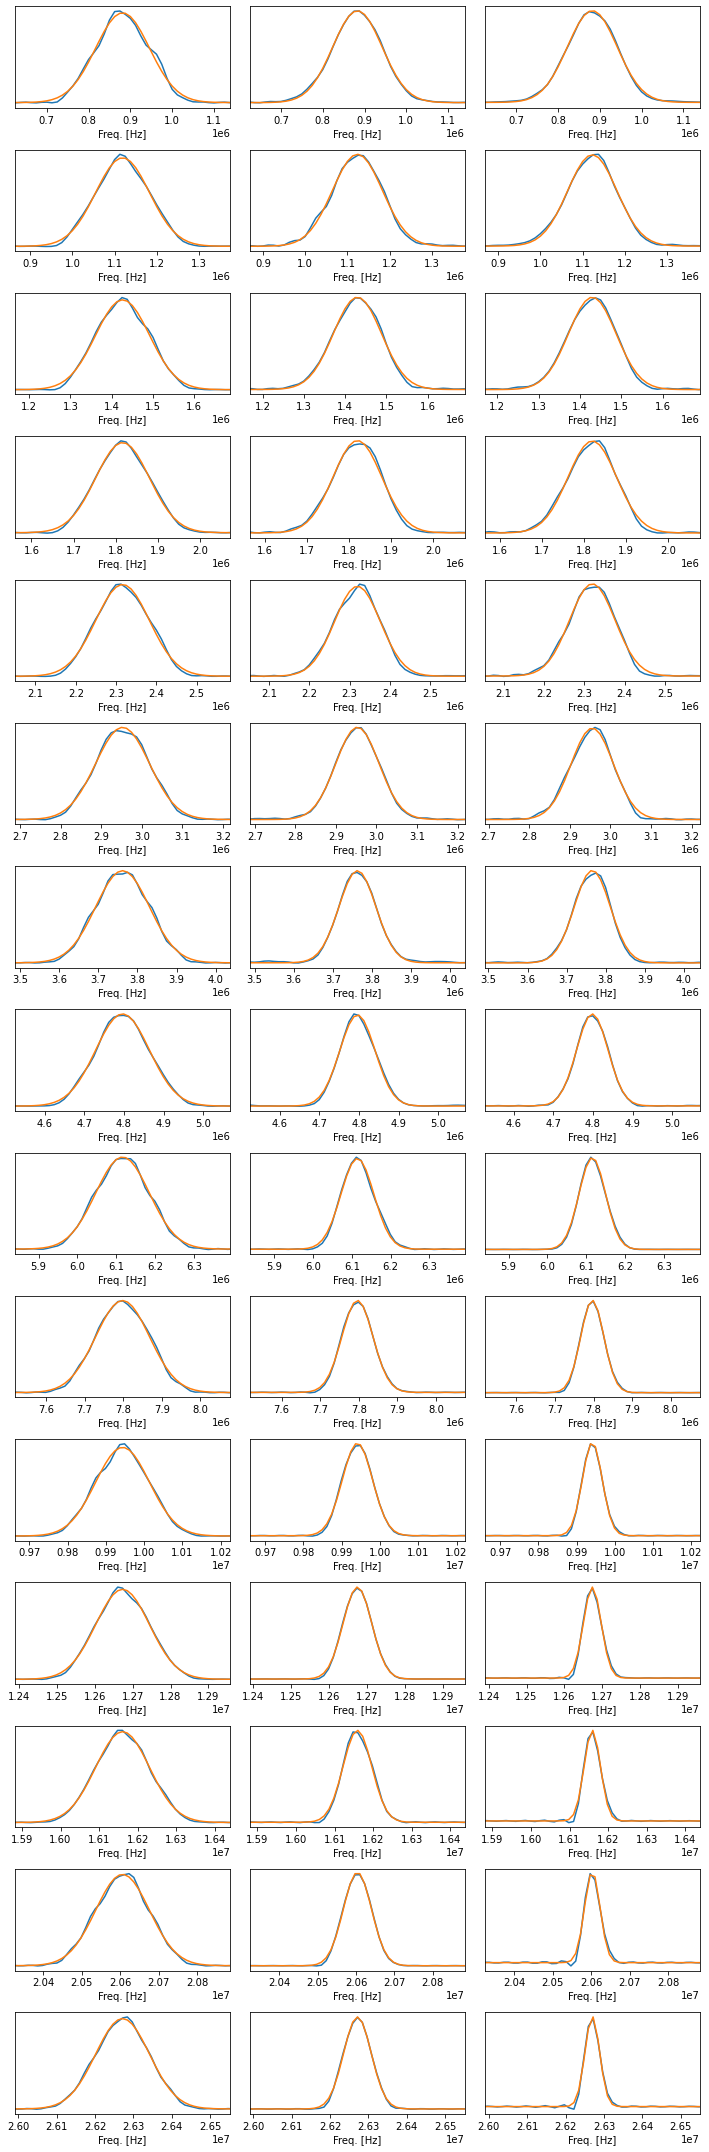

In [11]:
ncols = 3
nrows = fields
fig, axes = plt.subplots(nrows, ncols, figsize=(10,30))
l=0
for ax in axes.flat:
    i=l//3
    j=l%3
    ax.plot(xf,yf[i,j].real)
    ax.plot(xf,gauss(xf,amp[i,j], mean[i,j], stddev[i, j]))
    ax.set_xlim([mean[i,j]-4*np.max(stddev[i, :]),mean[i,j]+4*np.max(stddev[i, :])])
    ax.set(yticks=[])
    ax.set_xlabel('Freq. [Hz]')
    l += 1
fig.tight_layout()
plt.show()

Plot $b_{Har}$

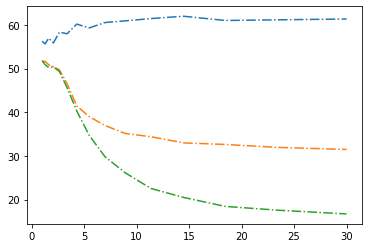

In [12]:
fig, axes = plt.subplots(1, 1)
axes.plot(factors,bhar[:,0], label = 'B // [1,0,0] axis', linestyle='-.')
axes.plot(factors,bhar[:,1], label = 'B // [1,1,0] axis', linestyle='-.')
axes.plot(factors,bhar[:,2], label = 'B // [1,1,1] axis', linestyle='-.')
plt.show()